In this notebook, you will use RF to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#load_dataset">Load the Cancer data</a></li>
        <li><a href="#modeling">Modeling</a></li>
        <li><a href="#evaluation">Evaluation</a></li>
        <li><a href="#practice">Practice</a></li>
    </ol>
</div>
<br>
<hr>

In [7]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

<h2 id="load_dataset">Load the Cancer data</h2>
The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

<br>
<br>



### Load Data From CSV File  

In [8]:
cell_df = pd.read_csv("cell_samples.csv")
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

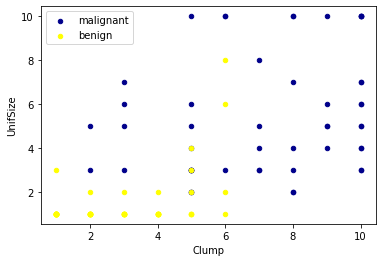

In [9]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

## Data pre-processing and selection

Lets first look at columns data types:

In [5]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

It looks like the __BareNuc__ column includes some values that are not numerical. We can drop those rows:

In [10]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [14]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [12]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

## Train/Test dataset

In [16]:
#Okay, we split our dataset into train and test set:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)
print('Train Data',X_train.shape, y_train.shape)
print('Test Data',X_test.shape,y_test.shape)

Train Data (546, 9) (546,)
Test Data (137, 9) (137,)


# Create Hyperparameter using Randomized search CV

In [18]:
#Randomized Serch CV
#No of trees in RF
n_estimators= [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
#No of faetures
max_features=['auto', 'sqrt','log2']
#Max depth for a RF
max_depth=[int(x) for x in np.linspace(10,1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
#min sample in each leaf node
min_samples_leaf = [1, 2, 4,6,8]
#Create a dictonary of a random_grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


#### Randomized Search CV

In [19]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import RandomizedSearchCV
rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=100,cv=3,verbose=2,random_state=100,n_jobs=1)
rf_randomcv.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=1000, criterion=entropy 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=1000, criterion=entropy, total=   0.6s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=1000, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=1000, criterion=entropy, total=   0.6s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=1000, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=1000, criterion=entropy, total=   0.6s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=120, criterion=gini 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=120, criterion=gini, total=   4.0s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=120, criterion=gini 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=120, criterion=gini, total=   4.2s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=120, criterion=gini 
[CV]  n_est

[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=780, criterion=entropy, total=   4.1s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=780, criterion=entropy 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=780, criterion=entropy, total=   4.1s
[CV] n_estimators=400, min_samples_split=14, min_samples_leaf=2, max_features=sqrt, max_depth=670, criterion=gini 
[CV]  n_estimators=400, min_samples_split=14, min_samples_leaf=2, max_features=sqrt, max_depth=670, criterion=gini, total=   1.1s
[CV] n_estimators=400, min_samples_split=14, min_samples_leaf=2, max_features=sqrt, max_depth=670, criterion=gini 
[CV]  n_estimators=400, min_samples_split=14, min_samples_leaf=2, max_features=sqrt, max_depth=670, criterion=gini, total=   1.2s
[CV] n_estimators=400, min_samples_split=14, min_samples_leaf=2, max_features=sqrt, max_depth=670, criterion=gini 
[CV]  n_est

[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=1000, criterion=entropy, total=   4.6s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=340, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=340, criterion=entropy, total=   0.6s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=340, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=340, criterion=entropy, total=   0.6s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=340, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=340, criterion=entropy, total=   0.6s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=log2, max_depth=780, criterion=gin

[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=8, max_features=log2, max_depth=1000, criterion=gini, total=   5.6s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=8, max_features=log2, max_depth=1000, criterion=gini 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=8, max_features=log2, max_depth=1000, criterion=gini, total=   5.8s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=8, max_features=log2, max_depth=1000, criterion=gini 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=8, max_features=log2, max_depth=1000, criterion=gini, total=   5.8s
[CV] n_estimators=1600, min_samples_split=14, min_samples_leaf=6, max_features=sqrt, max_depth=780, criterion=gini 
[CV]  n_estimators=1600, min_samples_split=14, min_samples_leaf=6, max_features=sqrt, max_depth=780, criterion=gini, total=   4.7s
[CV] n_estimators=1600, min_samples_split=14, min_samples_leaf=6, max_features=sqrt, max_depth=780, criterion=gini 
[CV]  n_esti

[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=780, criterion=gini, total=   2.3s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=780, criterion=gini 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=780, criterion=gini, total=   2.3s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=780, criterion=gini 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=780, criterion=gini, total=   2.3s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=560, criterion=entropy 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=560, criterion=entropy, total=   2.4s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=560, criterion=entropy 
[CV]  n_estima

[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=120, criterion=gini, total=   3.8s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=120, criterion=gini 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=120, criterion=gini, total=   3.9s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=120, criterion=gini 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=120, criterion=gini, total=   3.8s
[CV] n_estimators=1000, min_samples_split=14, min_samples_leaf=2, max_features=log2, max_depth=120, criterion=gini 
[CV]  n_estimators=1000, min_samples_split=14, min_samples_leaf=2, max_features=log2, max_depth=120, criterion=gini, total=   2.7s
[CV] n_estimators=1000, min_samples_split=14, min_samples_leaf=2, max_features=log2, max_depth=120, criterion=gini 
[CV]  n_estimator

[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=560, criterion=entropy, total=   5.7s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=560, criterion=entropy 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=560, criterion=entropy, total=   5.5s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=890, criterion=gini 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=890, criterion=gini, total=   2.2s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=890, criterion=gini 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=890, criterion=gini, total=   2.2s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=890, criterion=gini 
[CV]  n_estimato

[CV]  n_estimators=400, min_samples_split=14, min_samples_leaf=8, max_features=sqrt, max_depth=780, criterion=entropy, total=   1.2s
[CV] n_estimators=400, min_samples_split=14, min_samples_leaf=8, max_features=sqrt, max_depth=780, criterion=entropy 
[CV]  n_estimators=400, min_samples_split=14, min_samples_leaf=8, max_features=sqrt, max_depth=780, criterion=entropy, total=   1.1s
[CV] n_estimators=1200, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=450, criterion=gini 
[CV]  n_estimators=1200, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=450, criterion=gini, total=   3.3s
[CV] n_estimators=1200, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=450, criterion=gini 
[CV]  n_estimators=1200, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=450, criterion=gini, total=   3.5s
[CV] n_estimators=1200, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=450, criterion=gini 
[CV]  

[CV]  n_estimators=2000, min_samples_split=14, min_samples_leaf=1, max_features=sqrt, max_depth=10, criterion=gini, total=   5.7s
[CV] n_estimators=1600, min_samples_split=14, min_samples_leaf=4, max_features=auto, max_depth=340, criterion=gini 
[CV]  n_estimators=1600, min_samples_split=14, min_samples_leaf=4, max_features=auto, max_depth=340, criterion=gini, total=   5.6s
[CV] n_estimators=1600, min_samples_split=14, min_samples_leaf=4, max_features=auto, max_depth=340, criterion=gini 
[CV]  n_estimators=1600, min_samples_split=14, min_samples_leaf=4, max_features=auto, max_depth=340, criterion=gini, total=   4.9s
[CV] n_estimators=1600, min_samples_split=14, min_samples_leaf=4, max_features=auto, max_depth=340, criterion=gini 
[CV]  n_estimators=1600, min_samples_split=14, min_samples_leaf=4, max_features=auto, max_depth=340, criterion=gini, total=   5.0s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=670, criterion=entropy 
[CV]  n_est

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 16.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=100, verbose=2)

In [20]:
#Best Parameter in randomized serach
best_grid=rf_randomcv.best_estimator_
best_grid

RandomForestClassifier(max_depth=670, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=14, n_estimators=400)

In [21]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
y_pred=best_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print('accuracy',accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[86  4]
 [ 0 47]]
accuracy 0.9708029197080292
              precision    recall  f1-score   support

           2       1.00      0.96      0.98        90
           4       0.92      1.00      0.96        47

    accuracy                           0.97       137
   macro avg       0.96      0.98      0.97       137
weighted avg       0.97      0.97      0.97       137



#### Grid Search CV

In [22]:

rf_randomcv.best_params_

{'n_estimators': 400,
 'min_samples_split': 14,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 670,
 'criterion': 'gini'}

In [23]:
from sklearn.model_selection import GridSearchCV
#Create Param Dict
param_grid_1 = {
    'criterion': [rf_randomcv.best_params_['criterion']],
    'max_depth': [rf_randomcv.best_params_['max_depth']],
    'max_features': [rf_randomcv.best_params_['max_features']],
    'min_samples_leaf': [rf_randomcv.best_params_['min_samples_leaf'], 
                         rf_randomcv.best_params_['min_samples_leaf']+2, 
                         rf_randomcv.best_params_['min_samples_leaf'] + 4],
    'min_samples_split': [rf_randomcv.best_params_['min_samples_split'] - 2,
                          rf_randomcv.best_params_['min_samples_split'] - 1,
                          rf_randomcv.best_params_['min_samples_split'], 
                          rf_randomcv.best_params_['min_samples_split'] +1,
                          rf_randomcv.best_params_['min_samples_split'] + 2],
    'n_estimators': [rf_randomcv.best_params_['n_estimators'] - 200, rf_randomcv.best_params_['n_estimators'] - 100, 
                     rf_randomcv.best_params_['n_estimators'], 
                     rf_randomcv.best_params_['n_estimators'] + 100, rf_randomcv.best_params_['n_estimators'] + 200]
}
param_grid_1

{'criterion': ['gini'],
 'max_depth': [670],
 'max_features': ['sqrt'],
 'min_samples_leaf': [4, 6, 8],
 'min_samples_split': [12, 13, 14, 15, 16],
 'n_estimators': [200, 300, 400, 500, 600]}

In [24]:
rf=RandomForestClassifier()
grid_search=GridSearchCV(estimator=rf,param_grid=param_grid_1,cv=10,verbose=2)
grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 75 candidates, totalling 750 fits
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=500, total=   2.0s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=500, total=   1.5s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=500, total=   1.5s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=500, total=   1.6s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=500 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=13, n_estimators=300, total=   1.0s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=13, n_estimators=400 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=13, n_estimators=400, total=   1.1s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=13, n_estimators=400 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=13, n_estimators=400, total=   1.2s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=13, n_estimators=400 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=13, n_estimators=400, total=   1.2s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=13, n_estimators=400 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=200, total=   0.7s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=200 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=200, total=   0.6s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=200 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=200, total=   0.7s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=200 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=200, total=   0.6s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=200 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=500, total=   1.6s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=500 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=500, total=   1.2s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=500 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=500, total=   1.2s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=600 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=600, total=   1.6s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=14, n_estimators=600 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=400, total=   1.0s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=400 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=400, total=   0.9s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=400 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=400, total=   0.7s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=400 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=400, total=   1.0s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=400 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=200, total=   0.6s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=200 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=200, total=   0.5s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=200 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=200, total=   0.6s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=200 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=200, total=   0.7s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=200 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=500, total=   1.3s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=600 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=600, total=   1.8s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=600 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=600, total=   1.7s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=600 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=600, total=   1.8s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=4, min_samples_split=16, n_estimators=600 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=12, n_estimators=400, total=   0.8s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=12, n_estimators=400 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=12, n_estimators=400, total=   0.9s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=12, n_estimators=400 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=12, n_estimators=400, total=   0.8s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=12, n_estimators=400 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=12, n_estimators=400, total=   0.9s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=12, n_estimators=400 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=13, n_estimators=200, total=   0.4s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=13, n_estimators=200 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=13, n_estimators=200, total=   0.5s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=13, n_estimators=200 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=13, n_estimators=200, total=   0.5s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=13, n_estimators=300 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=13, n_estimators=300, total=   0.8s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=13, n_estimators=300 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=13, n_estimators=600, total=   1.4s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=13, n_estimators=600 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=13, n_estimators=600, total=   1.8s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=13, n_estimators=600 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=13, n_estimators=600, total=   1.7s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=13, n_estimators=600 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=13, n_estimators=600, total=   1.7s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=13, n_estimators=600 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=14, n_estimators=400, total=   1.3s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=14, n_estimators=400 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=14, n_estimators=400, total=   0.9s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=14, n_estimators=400 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=14, n_estimators=400, total=   0.8s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=14, n_estimators=400 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=14, n_estimators=400, total=   0.9s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=14, n_estimators=400 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=200, total=   0.6s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=300 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=300, total=   0.6s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=300 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=300, total=   0.7s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=300 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=300, total=   0.7s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=300 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=600, total=   1.8s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=600 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=600, total=   1.7s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=600 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=600, total=   1.7s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=600 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=600, total=   1.0s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=600 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=16, n_estimators=400, total=   1.1s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=16, n_estimators=400 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=16, n_estimators=400, total=   1.2s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=16, n_estimators=400 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=16, n_estimators=400, total=   1.1s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=16, n_estimators=500 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=16, n_estimators=500, total=   1.4s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=6, min_samples_split=16, n_estimators=500 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=300 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=300 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=300, total=   0.6s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=300 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=300, total=   0.8s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=300 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=600, total=   1.8s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=600 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=600, total=   1.8s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=600 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=600, total=   1.7s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=600 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=600, total=   1.7s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=12, n_estimators=600 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=13, n_estimators=400, total=   1.2s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=13, n_estimators=500 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=13, n_estimators=500, total=   1.5s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=13, n_estimators=500 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=13, n_estimators=500, total=   1.5s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=13, n_estimators=500 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=13, n_estimators=500, total=   1.5s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=13, n_estimators=500 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=300 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=300 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=300 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=300 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=600, total=   1.8s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=600 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=600, total=   1.8s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=600 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=600, total=   1.8s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=200 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=200, total=   0.6s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=200 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=500, total=   1.5s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=500 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=500, total=   1.5s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=500 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=500, total=   1.5s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=500 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=500, total=   1.5s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=500 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=16, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=16, n_estimators=300 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=16, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=16, n_estimators=300 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=16, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=16, n_estimators=300 
[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=16, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=16, n_estimators=300 
[CV]  criterion=gini

[CV]  criterion=gini, max_depth=670, max_features=sqrt, min_samples_leaf=8, min_samples_split=16, n_estimators=600, total=   1.8s


[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed: 13.9min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [670],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [4, 6, 8],
                         'min_samples_split': [12, 13, 14, 15, 16],
                         'n_estimators': [200, 300, 400, 500, 600]},
             verbose=2)

In [25]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=670, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=16, n_estimators=200)

In [26]:
y_pred=best_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[86  4]
 [ 0 47]]
Accuracy Score 0.9708029197080292
Classification report:               precision    recall  f1-score   support

           2       1.00      0.96      0.98        90
           4       0.92      1.00      0.96        47

    accuracy                           0.97       137
   macro avg       0.96      0.98      0.97       137
weighted avg       0.97      0.97      0.97       137

